# Interpetable YOLOv8 Demo on BR35H Dataset

In [1]:
import os
import torch
from PIL import Image, ImageDraw, ExifTags
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yolov8_interpretable import InterpretableYOLOTest

In [2]:
def load_model(model_path, model_class=None):
    # loading a custom model
    model = torch.load(model_path)
    model =  model['model'].float()
    model.eval()  # Set the model to evaluation mode
    return model

# Function to get the bounding box from the label file
def get_bounding_box_from_label(image_name, label_dir):
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))
    with open(label_path, 'r') as file:
        label = file.readline().strip().split()
    class_id, x_center, y_center, width, height = map(float, label)

    return [x_center, y_center, width, height]

def draw_bounding_box(image, bbox, target_size=(225, 225), original_size=(640, 640), color="red"):
    draw = ImageDraw.Draw(image)
    orig_width, orig_height = original_size
    target_width, target_height = target_size
    size = original_size[0]
    # YOLO format: [x_center, y_center, width, height]
    x_center, y_center, width, height = bbox


    x_center *= size
    y_center *= size
    width *= size
    height *= size



    x1 = x_center - (width / 2)
    y1 = y_center - (height / 2)
    x2 = x_center + (width / 2)
    y2 = y_center + (height / 2)

    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
    return image


label_dir = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/labels' 

In [3]:
data_yaml_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/data.yaml'
weights_path = '/home/alan/Documents/YOLOV8_interpretable/YOLOv8_weights/best.pt'
weights = load_model(weights_path, model_class=None)
target_layer_index = 140

Sample index: 0, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y0.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y0.txt


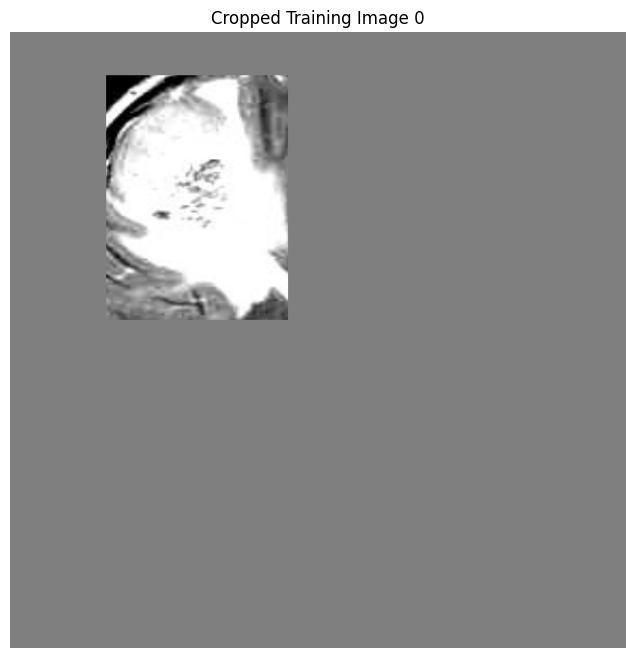

Sample index: 1, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y1.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y1.txt
Sample index: 2, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y10.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y10.txt
Sample index: 3, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y100.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y100.txt
Sample index: 4, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y101.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y101.txt
Sample

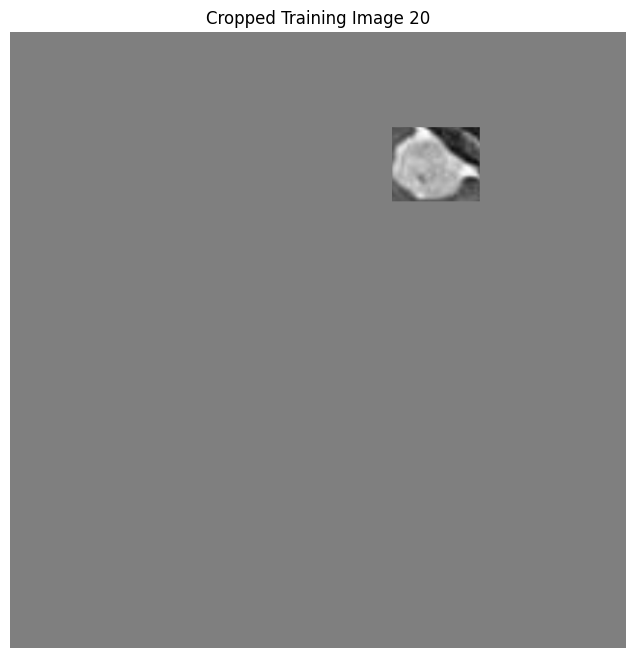

Sample index: 21, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y117.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y117.txt
Sample index: 22, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y118.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y118.txt
Sample index: 23, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y119.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y119.txt
Sample index: 24, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y12.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y12.tx

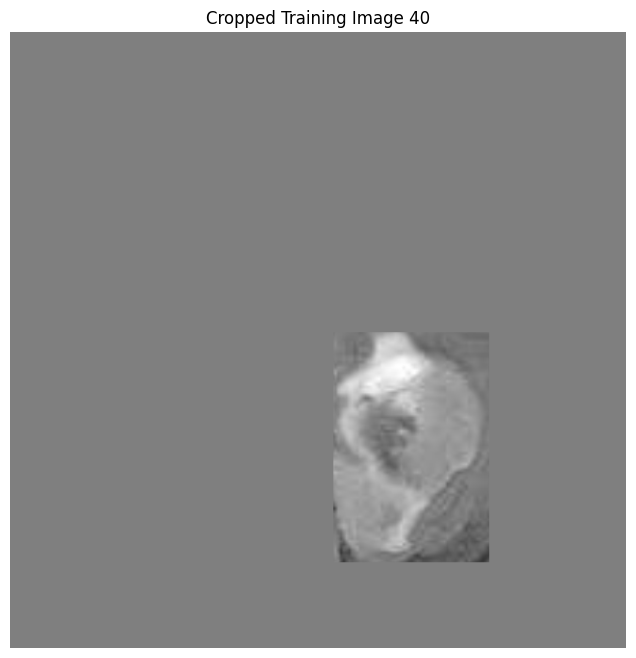

Sample index: 41, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y135.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y135.txt
Sample index: 42, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y136.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y136.txt
Sample index: 43, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y137.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y137.txt
Sample index: 44, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y138.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y138.

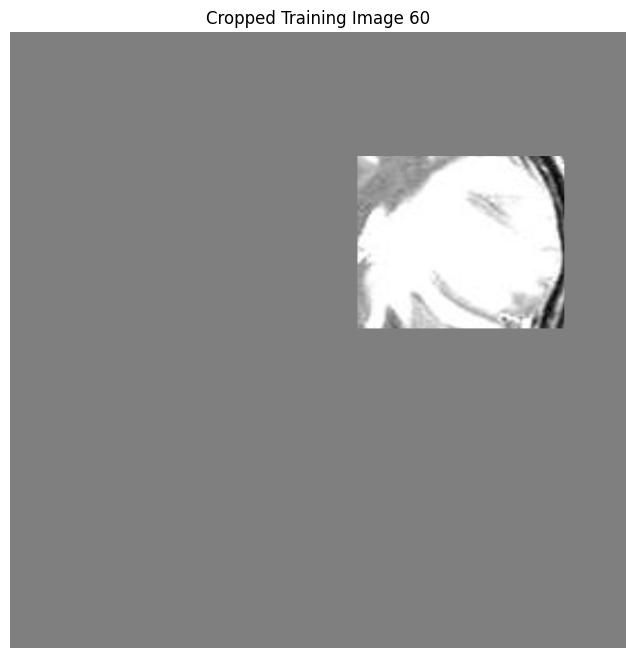

Sample index: 61, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y153.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y153.txt
Sample index: 62, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y154.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y154.txt
Sample index: 63, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y155.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y155.txt
Sample index: 64, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y156.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y156.

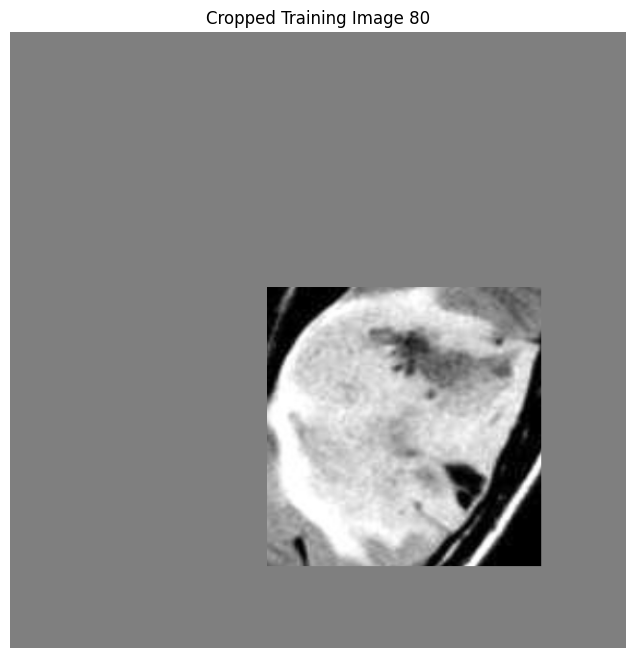

Sample index: 81, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y171.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y171.txt
Sample index: 82, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y172.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y172.txt
Sample index: 83, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y173.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y173.txt
Sample index: 84, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y174.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y174.

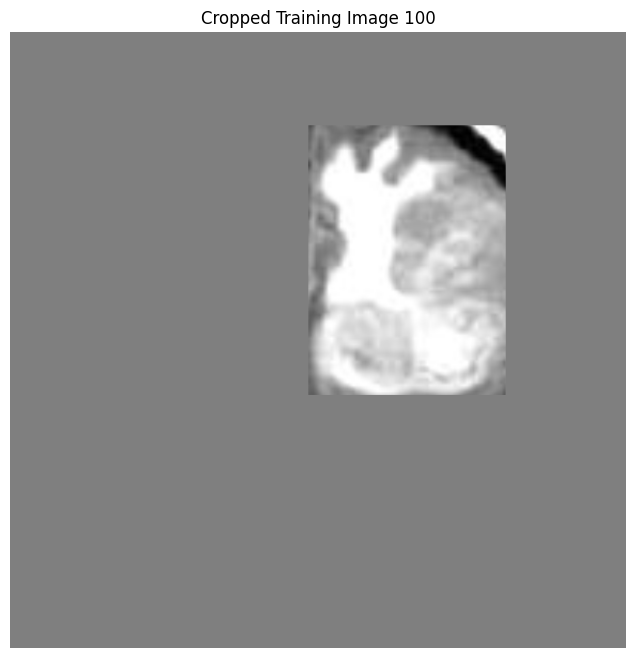

Sample index: 101, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y19.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y19.txt
Sample index: 102, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y190.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y190.txt
Sample index: 103, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y191.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y191.txt
Sample index: 104, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y192.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y19

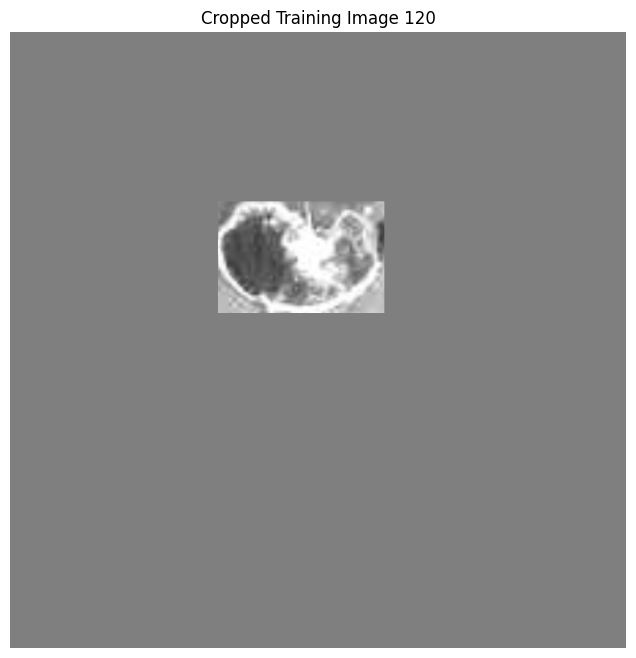

Sample index: 121, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y207.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y207.txt
Sample index: 122, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y208.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y208.txt
Sample index: 123, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y209.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y209.txt
Sample index: 124, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y21.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y2

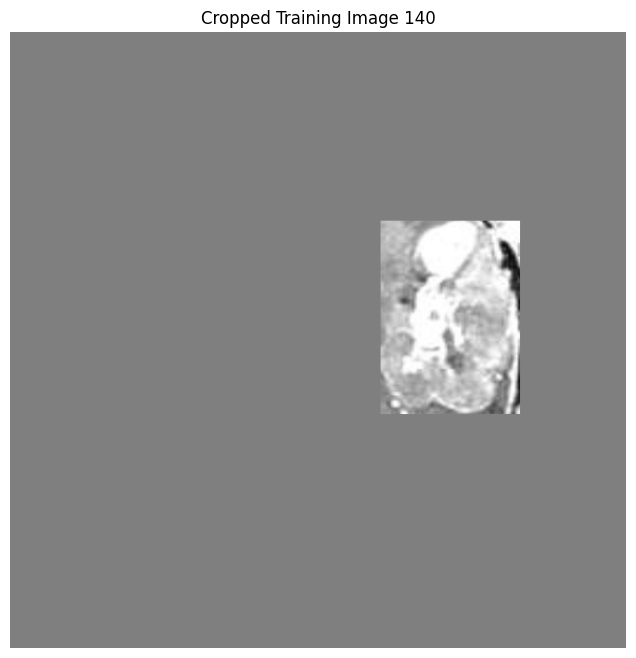

Sample index: 141, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y225.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y225.txt
Sample index: 142, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y226.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y226.txt
Sample index: 143, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y227.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y227.txt
Sample index: 144, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y228.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

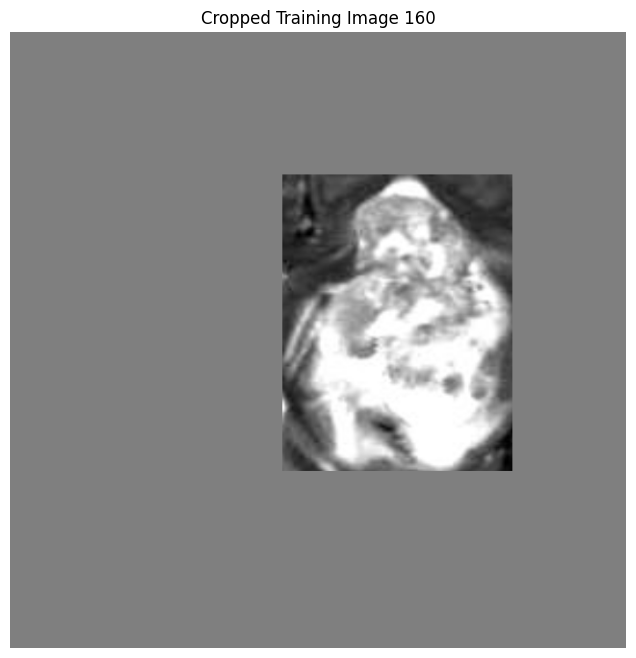

Sample index: 161, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y243.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y243.txt
Sample index: 162, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y244.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y244.txt
Sample index: 163, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y245.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y245.txt
Sample index: 164, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y246.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

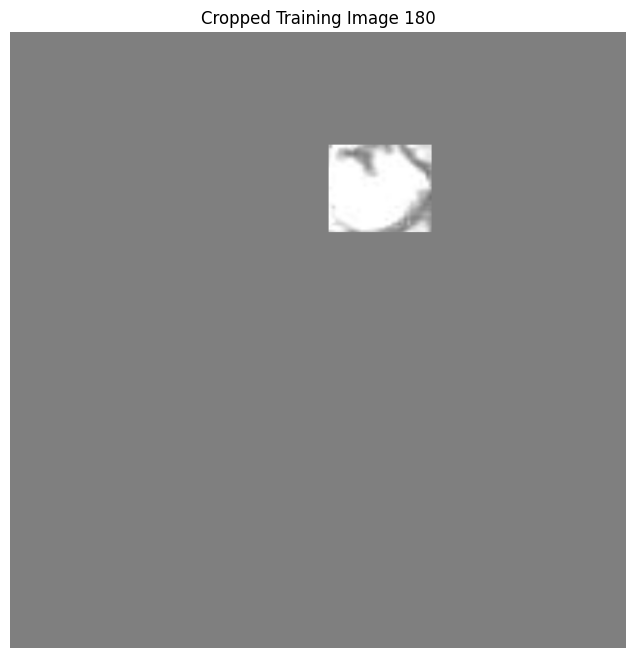

Sample index: 181, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y261.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y261.txt
Sample index: 182, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y262.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y262.txt
Sample index: 183, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y263.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y263.txt
Sample index: 184, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y264.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

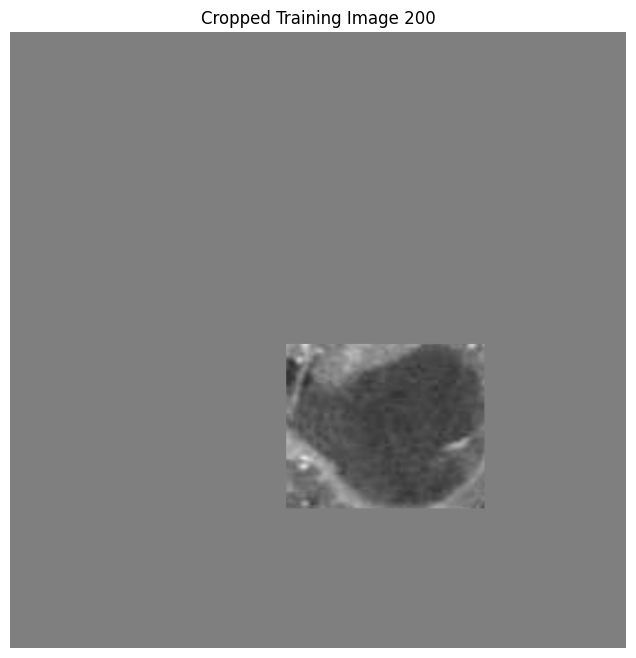

Sample index: 201, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y28.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y28.txt
Sample index: 202, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y280.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y280.txt
Sample index: 203, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y281.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y281.txt
Sample index: 204, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y282.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y28

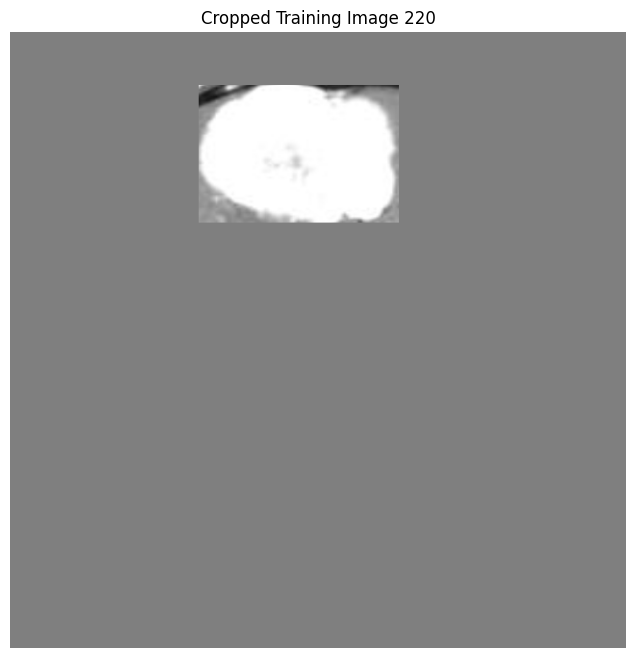

Sample index: 221, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y298.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y298.txt
Sample index: 222, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y299.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y299.txt
Sample index: 223, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y3.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y3.txt
Sample index: 224, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y30.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y30.tx

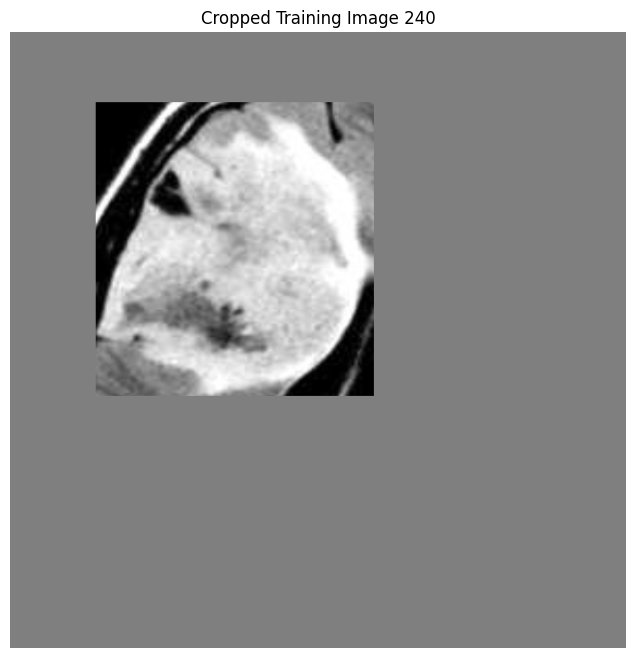

Sample index: 241, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y315.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y315.txt
Sample index: 242, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y316.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y316.txt
Sample index: 243, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y317.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y317.txt
Sample index: 244, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y318.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

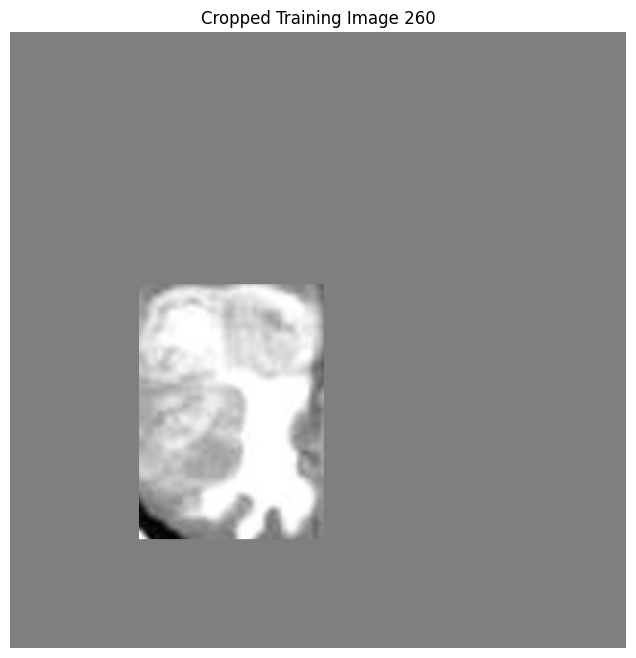

Sample index: 261, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y333.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y333.txt
Sample index: 262, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y334.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y334.txt
Sample index: 263, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y335.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y335.txt
Sample index: 264, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y336.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

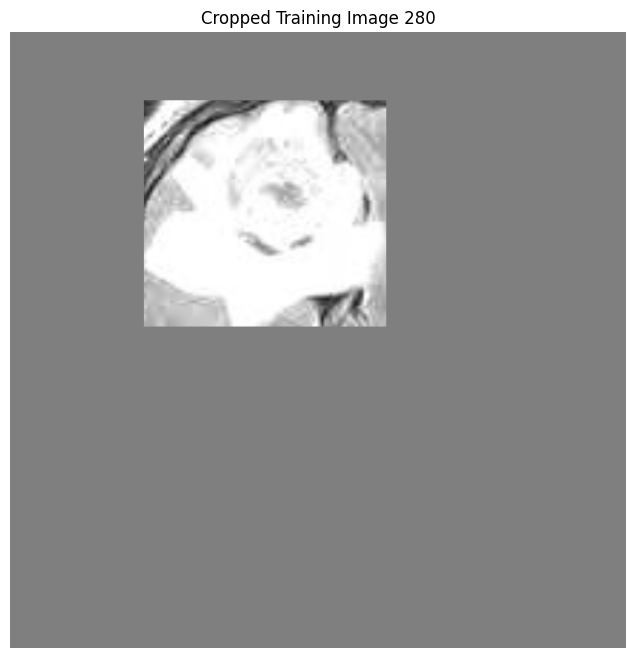

Sample index: 281, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y351.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y351.txt
Sample index: 282, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y352.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y352.txt
Sample index: 283, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y353.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y353.txt
Sample index: 284, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y354.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

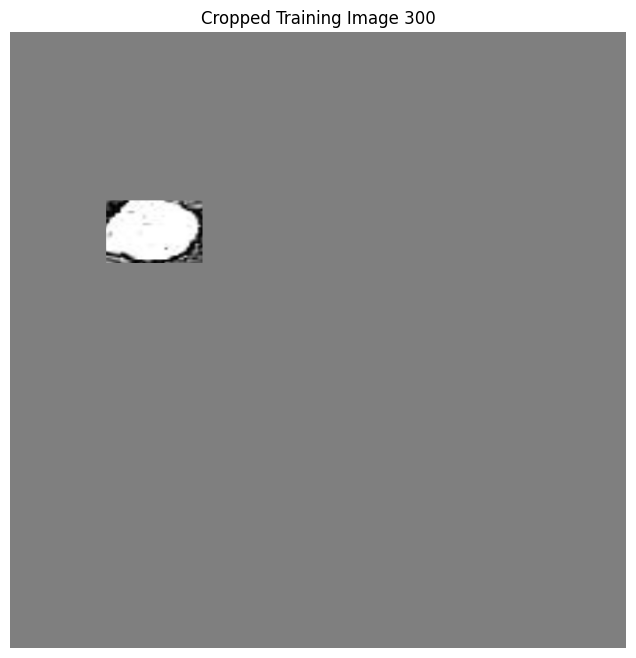

Sample index: 301, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y37.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y37.txt
Sample index: 302, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y370.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y370.txt
Sample index: 303, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y371.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y371.txt
Sample index: 304, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y372.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y37

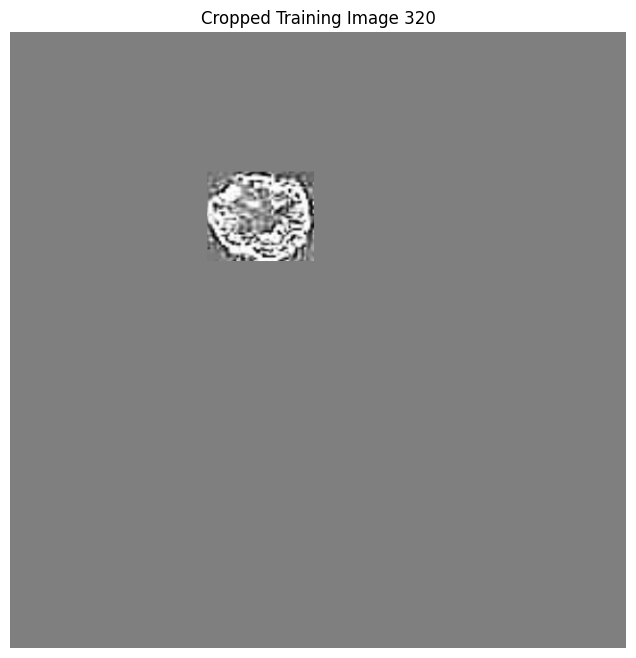

Sample index: 321, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y388.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y388.txt
Sample index: 322, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y389.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y389.txt
Sample index: 323, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y39.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y39.txt
Sample index: 324, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y390.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y39

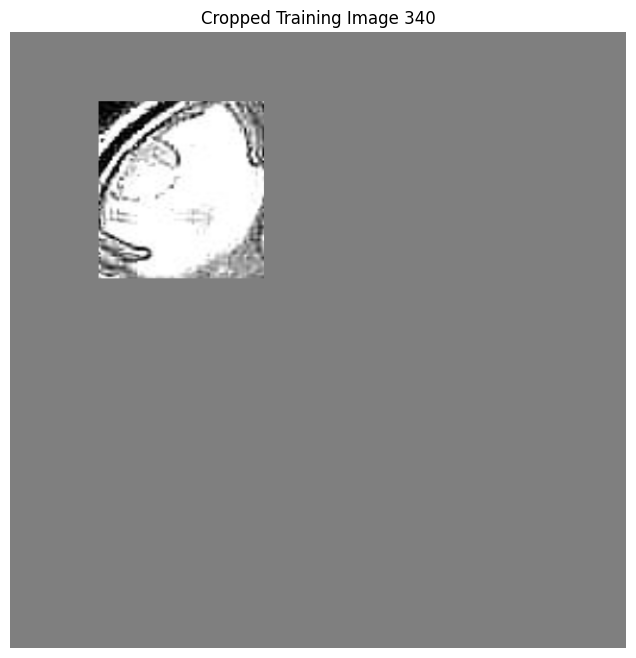

Sample index: 341, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y405.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y405.txt
Sample index: 342, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y406.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y406.txt
Sample index: 343, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y407.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y407.txt
Sample index: 344, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y408.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

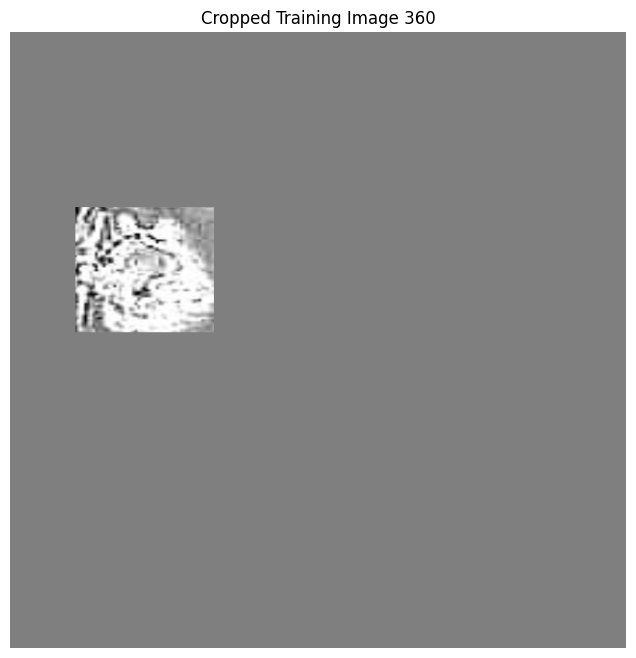

Sample index: 361, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y423.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y423.txt
Sample index: 362, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y424.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y424.txt
Sample index: 363, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y425.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y425.txt
Sample index: 364, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y426.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

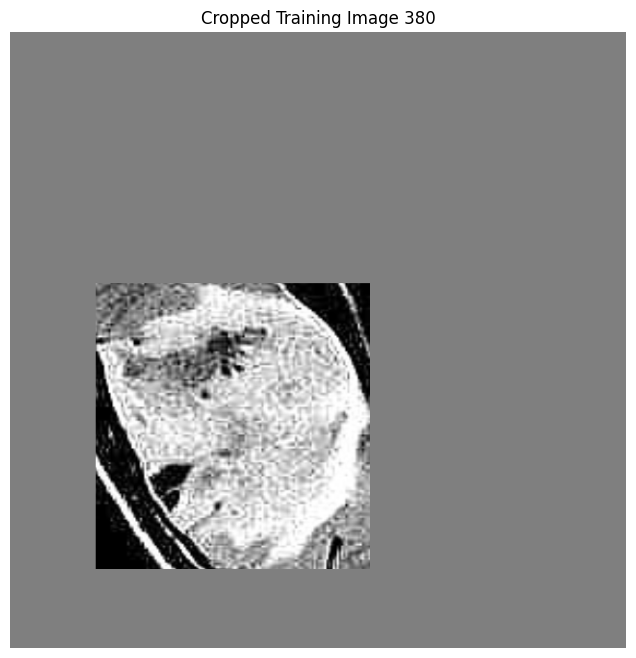

Sample index: 381, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y441.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y441.txt
Sample index: 382, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y442.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y442.txt
Sample index: 383, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y443.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y443.txt
Sample index: 384, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y444.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

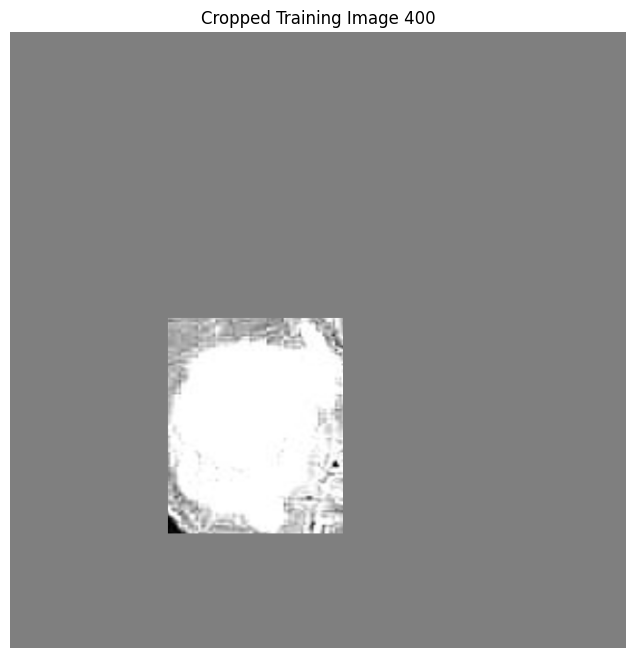

Sample index: 401, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y46.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y46.txt
Sample index: 402, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y460.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y460.txt
Sample index: 403, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y461.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y461.txt
Sample index: 404, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y462.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y46

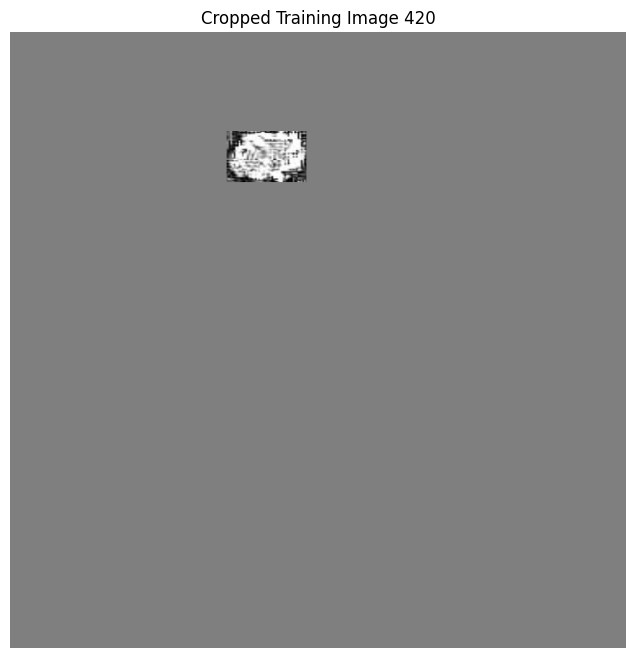

Sample index: 421, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y478.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y478.txt
Sample index: 422, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y479.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y479.txt
Sample index: 423, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y48.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y48.txt
Sample index: 424, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y480.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y48

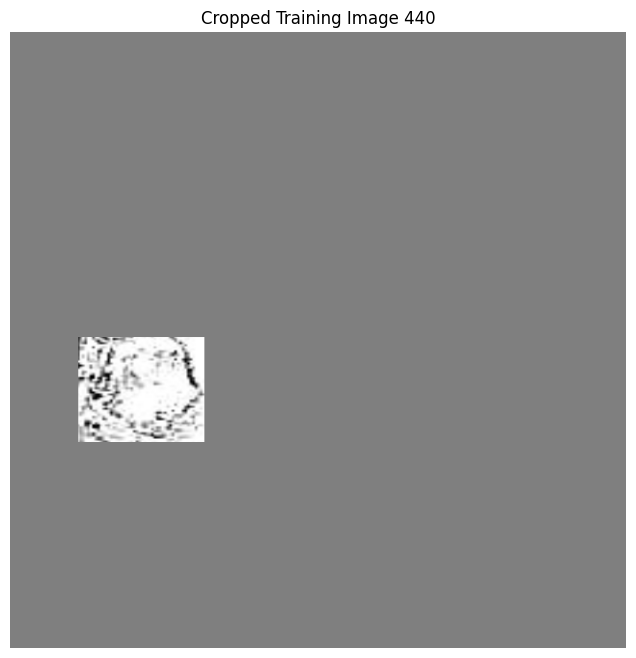

Sample index: 441, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y496.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y496.txt
Sample index: 442, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y497.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y497.txt
Sample index: 443, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y498.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y498.txt
Sample index: 444, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y499.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y

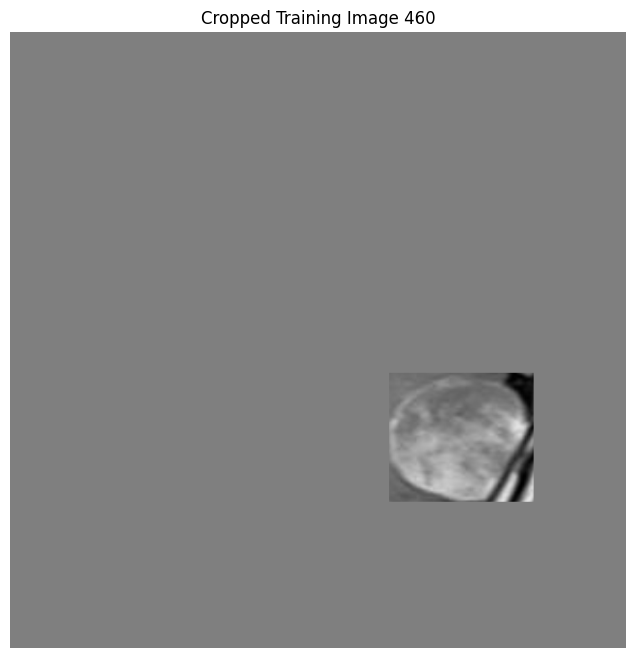

Sample index: 461, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y64.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y64.txt
Sample index: 462, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y65.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y65.txt
Sample index: 463, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y66.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y66.txt
Sample index: 464, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y67.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y67.txt


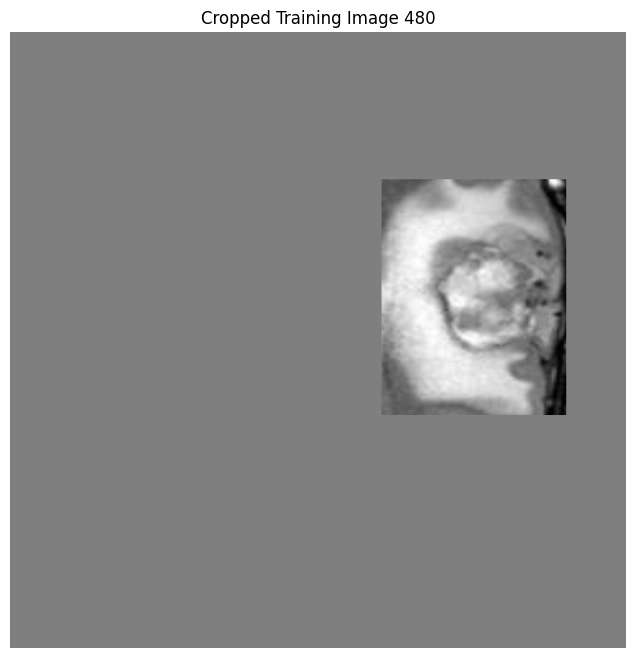

Sample index: 481, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y82.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y82.txt
Sample index: 482, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y83.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y83.txt
Sample index: 483, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y84.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y84.txt
Sample index: 484, Image Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/y85.jpg, Label Path: /home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/images/../labels/y85.txt


In [4]:
model = InterpretableYOLOTest(data_yaml_path, model=weights, target_layer_index=target_layer_index)

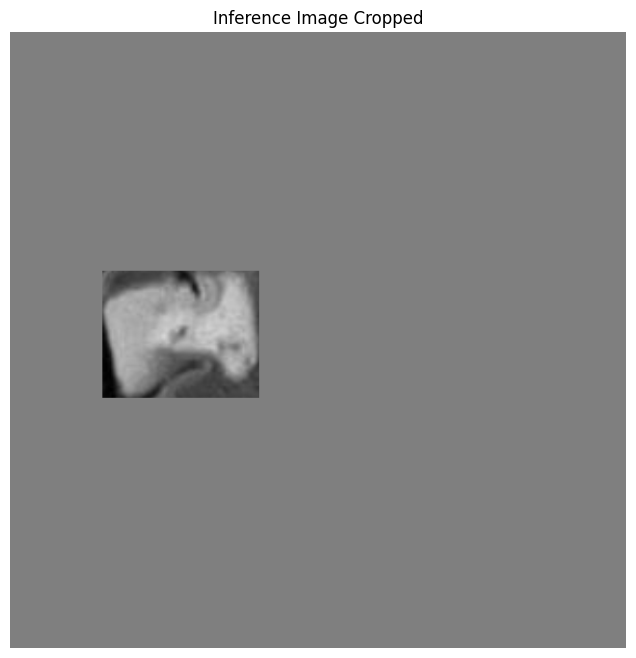

inference features size:  1
{'model_prediction': 0, 'confidence_score': 0.25623321533203125, 'bounding_box': array([    0.27755,     0.49122,     0.25474,      0.2052]), 'nearest_neighbors': ['y214.jpg', 'y123.jpg', 'y58.jpg', 'y352.jpg', 'y33.jpg'], 'distances': array([[      36510,       38068,       38219,       38468,       42912]], dtype=float32)}


In [42]:
inference_file = 'y705.jpg'
image_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/test/images/' + inference_file
k = 5
result = model.single_image_inference(image_path, k=k)
print(result)

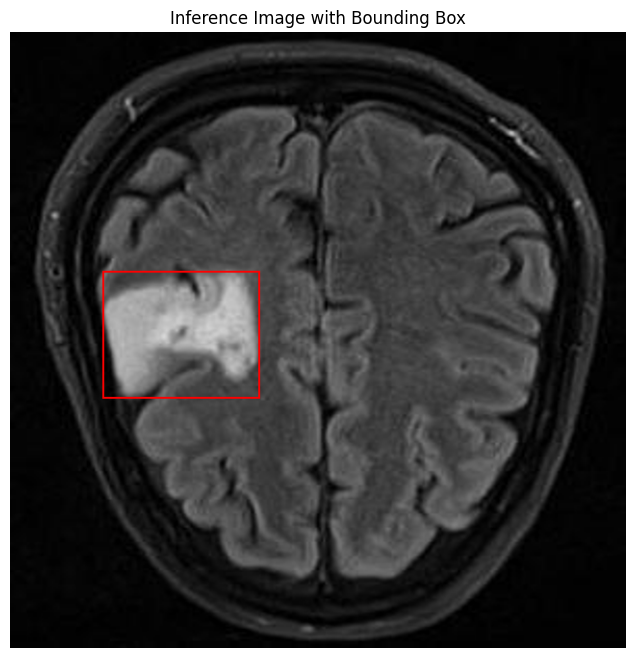

In [43]:
if result['bounding_box'] is not None:
    image = Image.open(image_path).resize((640, 640)) 
    inference_image_with_bbox = draw_bounding_box(image, result['bounding_box'])
    #compare with training bounding box groundtruth
    #inference_bbox= get_bounding_box_from_label(inference_file, label_dir)
    #inference_image_with_bbox = draw_bounding_box(image, inference_bbox)
    
    plt.figure(figsize=(8, 8))
    plt.title("Inference Image with Bounding Box")
    plt.imshow(inference_image_with_bbox)
    plt.axis('off')
    plt.show()

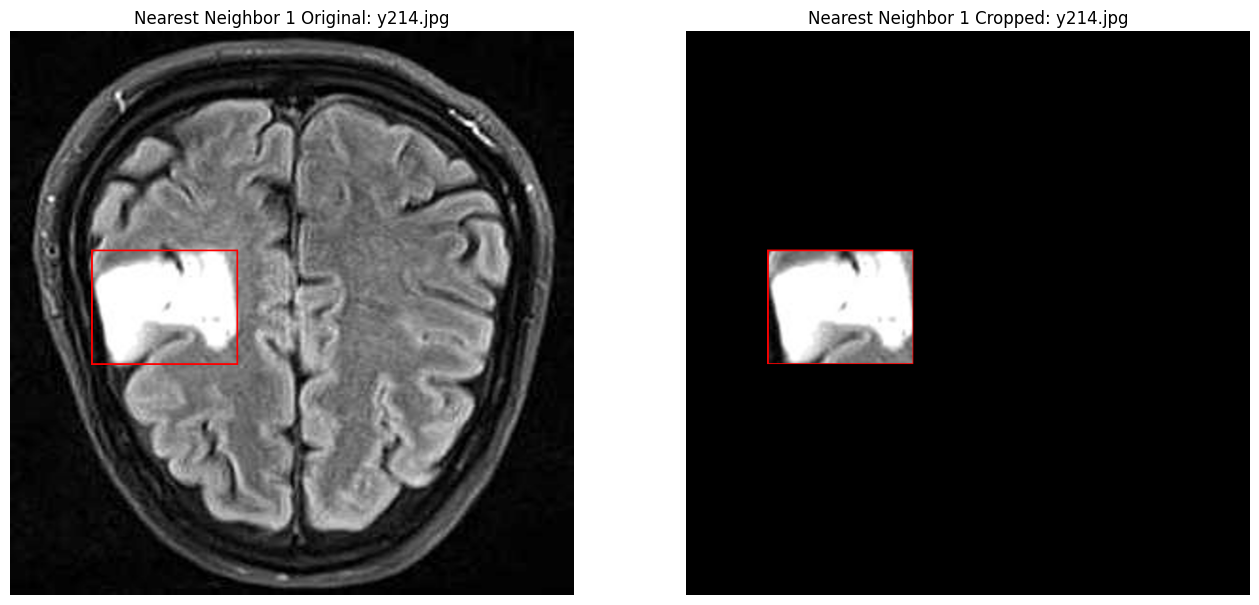

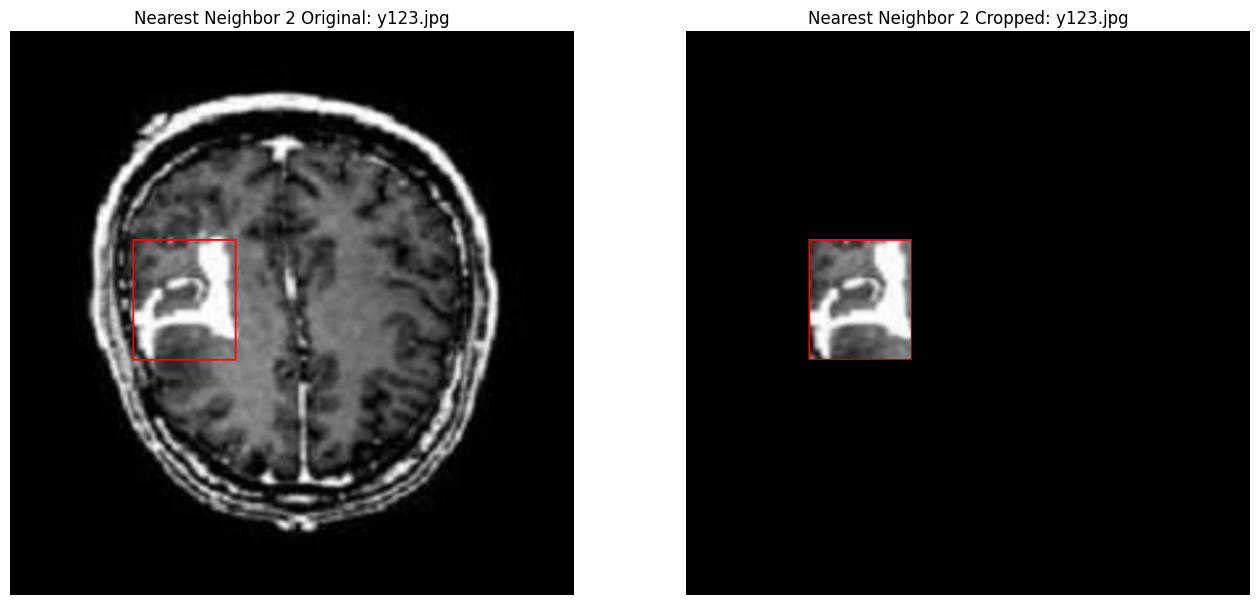

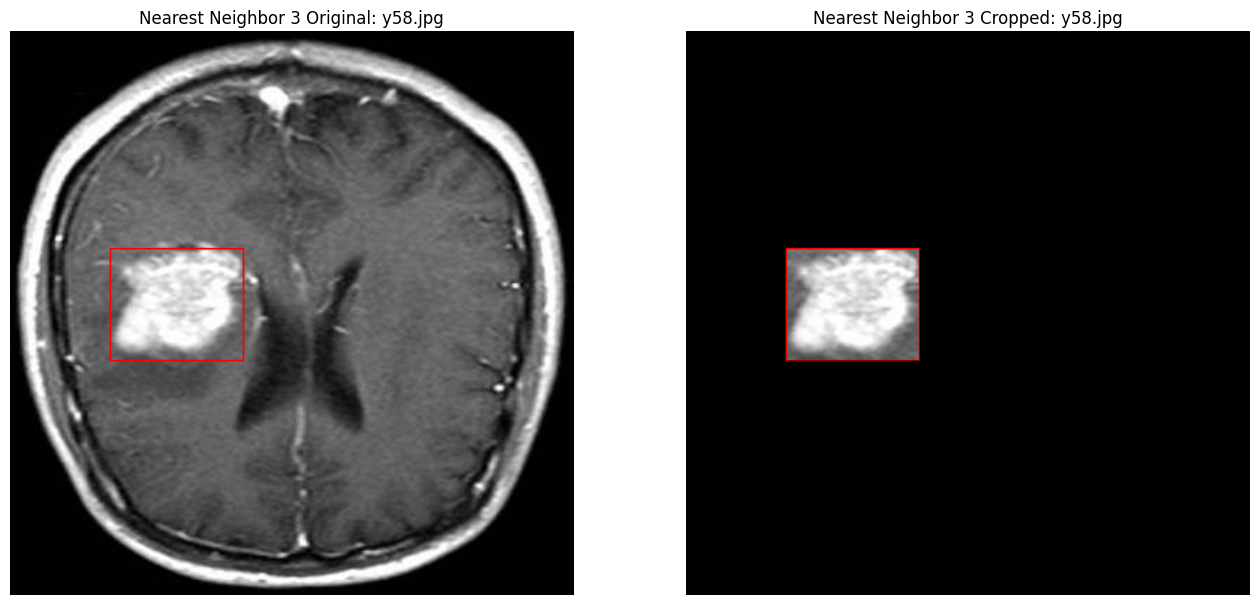

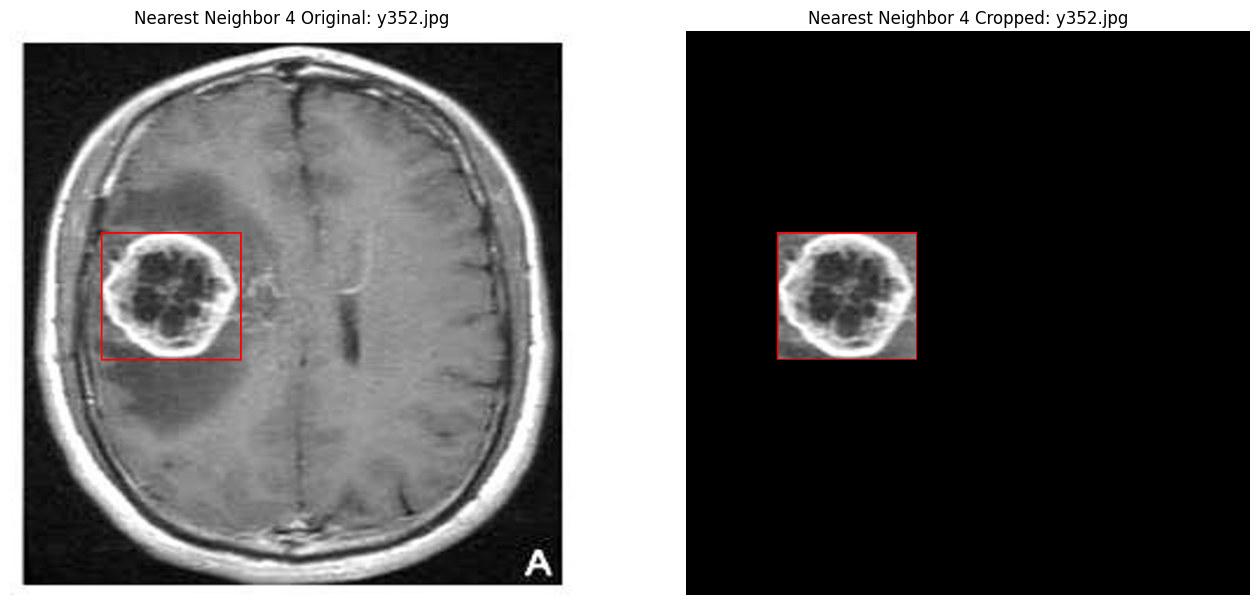

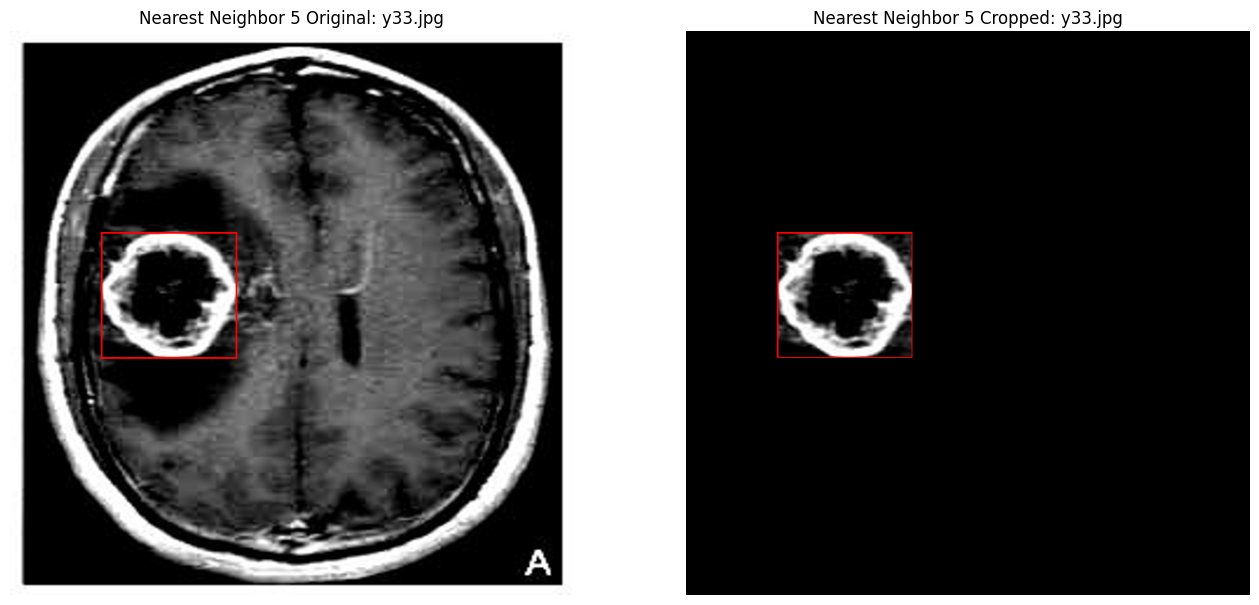

In [44]:
nearest_neighbors = result['nearest_neighbors']
i=1
for neighbor in nearest_neighbors:
    neighbor_image_path = os.path.join(model.train_loader.dataset.img_dir, neighbor)
    neighbor_image = Image.open(neighbor_image_path).resize((640, 640)) 

    neighbor_bbox = get_bounding_box_from_label(neighbor, label_dir)
    neighbor_image_with_bbox = draw_bounding_box(neighbor_image, neighbor_bbox)
    
    # Convert the neighbor image to a tensor
    neighbor_image_tensor = transforms.ToTensor()(neighbor_image).unsqueeze(0).to(model.device)
    
    # Crop the neighbor image using the crop_to_bounding_box function
    cropped_neighbor_image_tensor = model.crop_to_bounding_box(neighbor_image_tensor, [neighbor_bbox])
    
    # Convert the cropped tensor back to an image for visualization
    cropped_neighbor_image = transforms.ToPILImage()(cropped_neighbor_image_tensor.squeeze(0).cpu())
    
    # Display the original and cropped images side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(neighbor_image_with_bbox)
    axes[0].set_title(f"Nearest Neighbor {i} Original: {neighbor}")
    axes[0].axis('off')
    
    axes[1].imshow(cropped_neighbor_image, cmap='gray')
    axes[1].set_title(f"Nearest Neighbor {i} Cropped: {neighbor}")
    axes[1].axis('off')
    
    plt.show()
    i+=1